In [1]:
# Necessary modules
import pandas as pd
import numpy  as np

from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation, Flatten
from keras.layers     import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using Theano backend.


In [40]:
# Get the data
data = pd.read_csv(filepath_or_buffer="../data/face_image_project/fold_0_data.txt", sep="\t")
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,68825596@N05,11594021023_9744cdf4d8_o.jpg,296,"(4, 6)",f,0,15,723,724,-70,0,43
1,20254529@N04,9981870036_a1198b3d04_o.jpg,14,"(4, 6)",f,1216,449,1332,1332,0,30,91
2,9017386@N06,10770880025_bc9af5c520_o.jpg,211,"(38, 43)",m,396,543,287,287,0,0,55
3,113605644@N05,11817301845_0219448693_o.jpg,417,"(0, 2)",m,25,0,1104,960,-100,0,143
4,30601258@N03,9347577463_4db4ea3de9_o.jpg,2,"(25, 32)",m,1034,651,1058,1059,-95,0,17


In [41]:
data = data[["user_id","original_image","face_id","gender", "age"]]
data.head()

,user_id,original_image,face_id,gender,age
0,68825596@N05,11594021023_9744cdf4d8_o.jpg,296,f,"(4, 6)"
1,20254529@N04,9981870036_a1198b3d04_o.jpg,14,f,"(4, 6)"
2,9017386@N06,10770880025_bc9af5c520_o.jpg,211,m,"(38, 43)"
3,113605644@N05,11817301845_0219448693_o.jpg,417,m,"(0, 2)"
4,30601258@N03,9347577463_4db4ea3de9_o.jpg,2,m,"(25, 32)"


In [42]:
data = data[data.gender != "u"]
data.gender.value_counts()

m    2047
f    1948
Name: gender, dtype: int64

In [43]:
data.loc[data.gender == "f", "gender"] = 0
data.loc[data.gender == "m", "gender"] = 1
data.head()

,user_id,original_image,face_id,gender,age
0,68825596@N05,11594021023_9744cdf4d8_o.jpg,296,0,"(4, 6)"
1,20254529@N04,9981870036_a1198b3d04_o.jpg,14,0,"(4, 6)"
2,9017386@N06,10770880025_bc9af5c520_o.jpg,211,1,"(38, 43)"
3,113605644@N05,11817301845_0219448693_o.jpg,417,1,"(0, 2)"
4,30601258@N03,9347577463_4db4ea3de9_o.jpg,2,1,"(25, 32)"


In [ ]:
path_template = "../data/face_image_project/aligned/%s/landmark_aligned_face.%d.%s"
data["file_path"] = data[["user_id","face_id","original_image"]].apply(lambda x:  
                                                                   path_template % (x[0],x[1],x[2]),
                                                                   axis=1)
data.head()

In [67]:
data.age[11] == 'None'

True

In [73]:
data = data[data.age != 'None']

In [ ]:
data = data[["file_path","gender", "age"]]
data = pd.get_dummies(data, columns=["age"])
data.head()

In [88]:
len(data.columns)

19

In [93]:
data.columns

Index([u'file_path', u'gender', u'age_(0, 2)', u'age_(15, 20)',
       u'age_(25, 32)', u'age_(38, 43)', u'age_(38, 48)', u'age_(4, 6)',
       u'age_(48, 53)', u'age_(60, 100)', u'age_(8, 12)', u'age_13', u'age_22',
       u'age_3', u'age_35', u'age_36', u'age_45', u'age_55', u'age_58'],
      dtype='object')

In [95]:
age_cols =  [u'age_(0, 2)', u'age_(15, 20)',
       u'age_(25, 32)', u'age_(38, 43)', u'age_(38, 48)', u'age_(4, 6)',
       u'age_(48, 53)', u'age_(60, 100)', u'age_(8, 12)', u'age_13', u'age_22',
       u'age_3', u'age_35', u'age_36', u'age_45', u'age_55', u'age_58']
len(age_cols)

17

### So there are 17 age categories...

In [101]:
import scipy.misc

i_width  = 227
i_height = 227

#scipy.misc.imresize(original_image, (i_height, i_width))


def train_generator(data):
    while True:
        start, end = 0, 32
        while end < len(data):
            data = data.sample(frac=1).reset_index(drop=True)
            sample  = data[start:end]

            X = pd.DataFrame(sample["file_path"].apply(lambda x:  img_to_array( scipy.misc.imresize(load_img(x), (i_height, i_width) ) ) ))
            
            X = X["file_path"].apply(lambda x: x.reshape((1,)+ x.shape))
            X = np.vstack(X)
            #print X[0].shape
            #print X.shape
            #
            Y = sample[age_cols].as_matrix()
            #print Y.as_matrix()
            #print Y.shape
            #print X
            yield (X, Y)
            start += 32
            end += 32

(32, 227, 227, 3)
(32, 17)


In [98]:
a,b = train_generator(data).next()

(32, 227, 227, 3)
(32, 17)


In [90]:
# Building a vainilla CNN
vainilla_cnn = Sequential()
vainilla_cnn.add(Convolution2D(32, 3, 3, input_shape=(227,227,3)))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Convolution2D(64, 3, 3))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(Convolution2D(64, 3, 3))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Flatten())
vainilla_cnn.add(Dense(output_dim=200, input_dim=500))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=100, input_dim=200))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=17))
vainilla_cnn.add(Activation("softmax"))

In [102]:
vainilla_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
history = vainilla_cnn.fit_generator(train_generator(data), samples_per_epoch=64, nb_epoch=200)

Epoch 1/200
64/64 [==============================] - 19s - loss: 2.7521 - acc: 0.2656    
Epoch 2/200
64/64 [==============================] - 19s - loss: 2.9546 - acc: 0.2188    
Epoch 3/200
64/64 [==============================] - 18s - loss: 2.6796 - acc: 0.2656    
Epoch 4/200
64/64 [==============================] - 18s - loss: 2.5652 - acc: 0.3125    
Epoch 5/200
64/64 [==============================] - 19s - loss: 2.2829 - acc: 0.3750    
Epoch 6/200
64/64 [==============================] - 22s - loss: 2.7411 - acc: 0.2969     
Epoch 7/200
64/64 [==============================] - 19s - loss: 2.2047 - acc: 0.3750     
Epoch 8/200
64/64 [==============================] - 23s - loss: 2.1619 - acc: 0.4219     
Epoch 9/200
64/64 [==============================] - 24s - loss: 2.1908 - acc: 0.3906     
Epoch 10/200
64/64 [==============================] - 22s - loss: 2.0013 - acc: 0.3750     
Epoch 11/200
64/64 [==============================] - 20s - loss: 2.2875 - acc: 0.3594     
Ep

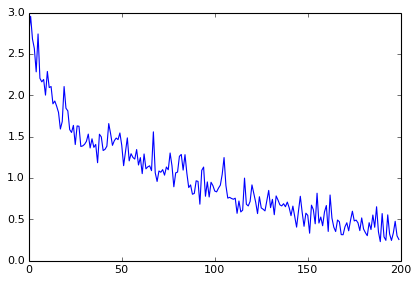

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])

NameError: name 'vainilla_cnn' is not defined